In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style()

In [2]:
df = pd.read_csv('data/05/regrfunc.csv')

df

,Unnamed: 0,uu,x,y,z
0,1,11.763391,12.293460,3.844498,17.501964
1,2,22.163610,8.618145,5.967595,11.799575
2,3,16.180178,10.743269,5.088272,11.750892
3,4,21.465015,10.331320,6.278596,18.576234
4,5,28.019913,8.367181,7.762348,14.266933
...,...,...,...,...,...
495,496,22.837556,11.336223,7.636338,16.856832
496,497,29.382229,6.904615,5.537287,26.258819
497,498,32.688396,10.107055,7.901569,35.027569
498,499,22.944410,10.529317,6.120940,26.431222


In [3]:
X = df[['x', 'y', 'z']]

X

,x,y,z
0,12.293460,3.844498,17.501964
1,8.618145,5.967595,11.799575
2,10.743269,5.088272,11.750892
3,10.331320,6.278596,18.576234
4,8.367181,7.762348,14.266933
...,...,...,...
495,11.336223,7.636338,16.856832
496,6.904615,5.537287,26.258819
497,10.107055,7.901569,35.027569
498,10.529317,6.120940,26.431222


In [4]:
y = df['uu']

y

0      11.763391
1      22.163610
2      16.180178
3      21.465015
4      28.019913
         ...    
495    22.837556
496    29.382229
497    32.688396
498    22.944410
499    17.128552
Name: uu, Length: 500, dtype: float64

In [5]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.metrics import r2_score

model = LinReg(n_jobs=4).fit(X, y)

y_pred = model.predict(X)

r2_score(y, y_pred)

0.9676484197365328

Ух ты, реально очень хорошо. Посмотрим на то, какие коэффициенты выдаёт модель:

In [6]:
model.coef_, model.intercept_

(array([-1.67182374,  2.88367908,  0.2635388 ]), 15.866910678602096)

Ладно, попробуем нагенерировать точек из реального распределения и с такими коэффициентами, но для начала посмотрим, на какой области у нас заданы данные:

In [7]:
(X['x'].min(), X['x'].max()), (X['y'].min(), X['y'].max()), (X['z'].min(), X['z'].max())

((5.42477772623841, 14.1618706179291),
 (0.379386871058437, 11.6259684018472),
 (-4.93883666807515, 40.3032298087004))

In [8]:
grid = np.meshgrid(np.arange(5., 15., 0.25), np.arange(0., 12., 0.25), np.arange(-5., 40., 0.25), indexing='ij')

In [9]:
def real_f(row):
    return np.sqrt(1200 + row[2] ** 2) * np.arctan(row[1] / row[0])

Ладно, идея неудачная, потому что мы отобразить это не сможем, ведь понадобится четырехмерное пространство. Посмотрим как у нас набросаны наши точки:

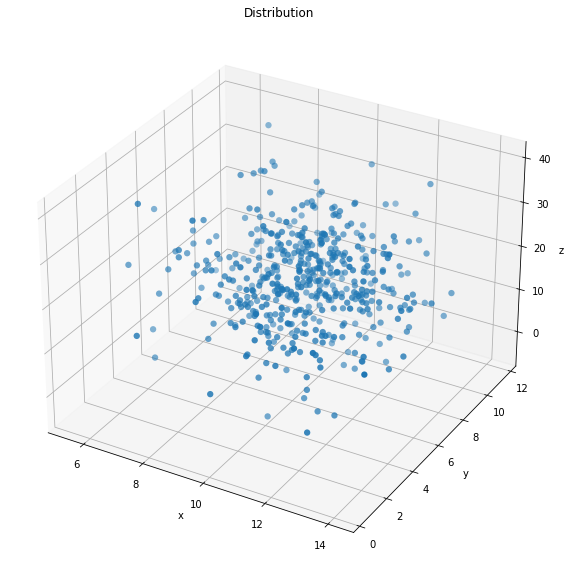

In [10]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
ax.scatter3D(X.x, X.y, X.z, cmap='viridis', edgecolor='none', s=40)
ax.set_title('Distribution');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Мысль - попробуем разложить нашу функцию в ряд тейлора около точки наибольшего скопления наших данных, то есть:

In [11]:
X.x.mean(), X.y.mean(), X.z.mean()

(10.383379665233644, 6.0594274598037, 20.36948431387669)

Ну типа примем $x_0 = 10, y_0 = 6, z_0 = 20$ и разложим в тейлора до второго порядка (сейчас будет больно):

$$f = f_0 + \frac{1}{1!} \left(\frac{\delta f_0}{\delta x} (x-x_0) + \frac{\delta f_0}{\delta y} (y-y_0) + \frac{\delta f_0}{\delta z} (z-z_0)\right) + \frac{1}{2!} \left(\ldots\right) + \mathcal{o}(d^2)$$

Погнали мучаться:

$$f_0 = 40 \arctan\left(\frac{3}{5}\right)$$
$$\frac{\delta f_0}{\delta x} = -\frac{y \sqrt{1200+z^2}}{x^2 + y^2} = -\frac{30}{17}$$
$$\frac{\delta f_0}{\delta y} = \frac{x \sqrt{1200+z^2}}{x^2 + y^2} = \frac{50}{17}$$
$$\frac{\delta f_0}{\delta z} = \frac{z \cdot \arctan\left(\frac{y}{x}\right)}{\sqrt{1200 + z^2}} = \frac{1}{2} \arctan\left(\frac{3}{5}\right)$$

In [12]:
40 * np.arctan(3/5), -30/17, 50/17, np.arctan(3/5) / 2

(21.616780010823366,
 -1.7647058823529411,
 2.9411764705882355,
 0.2702097501352921)

Можно заметить, что это очень похоже на коэффициенты линейной модели!

In [13]:
def analytic_f(row):
    return 40 * np.arctan(3/5) + -30/17 * (row[0] - 10) + 50/17 * (row[1] - 6) + np.arctan(3/5) / 2 * (row[2] - 20)

y_analytic = np.apply_along_axis(analytic_f, 1, X)

r2_score(y, y_analytic)

0.9664552496511694

Эксперимент, можно сказать, очень удался. Всё ещё видно, что $k_1$, $k_2$ и $k_3$ похожи на коэффициенты линейной модели.

На самом деле, ещё из разложения Тейлора становится понятно, что коэффициенты при квадратах достаточно малы в интересующих нас окрестностях, поэтому функция там практически линейная.

Если что, я посчитал вторые производные, но мне стало так лень перебивать их из вольфрама.